# Coaquisitions analyses by gene length

In [1]:
data_dir = '../data/'
taxonomic_id = '1236'
compiled_res_dir = '../data/compiled_results/'
plots_dir = '../plots/'

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import matplotlib as mpl

# use plotly for interactive plots
from plotly.offline import plot
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import math

import json
# read in the marker styles
with open('lib/plot_marker_styles.json', 'r') as f:
    marker_styles_dict = json.load(f)['marker_styles_dict']
    # this is a dictionary such that for each method it contains
    # a dict of marker styles for 'pyplot', 'plotly', 'marker_color', 'face_color'

neighbor_genes_between_cutoffs = [1]
minimum_genome_size = 1000  # minimum genome size to consider a genome (i.e. contig or chromosome) for analysis
min_coacquisitions = 10  # minimum number of coacquisitions to consider a threshold of a method for analysis
# minimum number of coacquisitions with known positions, as a certain numerator, for considering it for percentage calculation
# e.g. for the percentage of coacquisitions that are neighbors,
# we need at least this meany neighbors that are coacquired for a given transfer threshold of a method to be considered
min_numerator = 0  # if 0, then in paper we add notes about the fact that there may be small number effects

In [3]:
plt_style_file = 'lib/plot.mplstyle'
plt.style.use(plt_style_file)
mpl.rc_file(plt_style_file)
# Scale the relevant rcParams by 2x
scale_factor = 1.5
for key in mpl.rcParams:
    try:
        if not 'size' in key:
            continue
        if isinstance(mpl.rcParams[key], (int, float)) and not isinstance(mpl.rcParams[key], bool):
            mpl.rcParams[key] *= scale_factor
        elif isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [v*scale_factor if isinstance(v, (int, float)) and not isinstance(v, bool) else v for v in mpl.rcParams[key]]
    except Exception as e:
        print(f"Error scaling {key} from {mpl.rcParams[key]}: {e}")
        raise e    

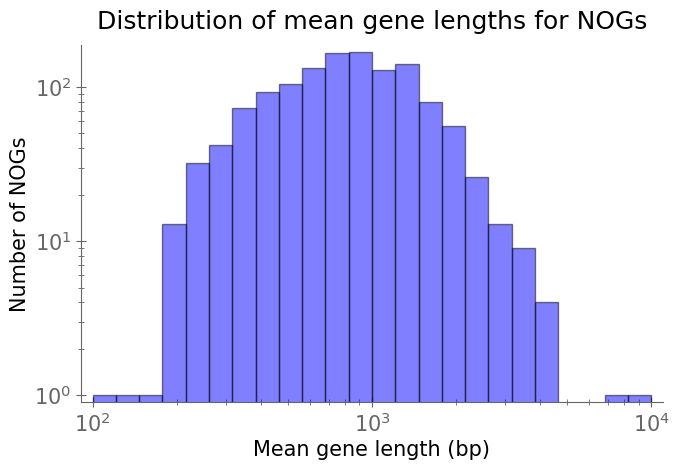

Short bin: 625.5782105263158, Medium bin: 1028.5372294372294, Long bin: 8575.764705882353
Number of NOGs in short genes bin: 425
Number of NOGs in medium genes bin: 424
Number of NOGs in long genes bin: 437


In [4]:
# read in the gene length file for this taxonomic id
gene_features_filepath = f'{data_dir}/{taxonomic_id}_gene_features.tsv'
gene_features_df = pd.read_csv(gene_features_filepath, sep='\t')
gene_features_df.loc[:, 'full_gene_id'] = gene_features_df['taxon_id'].astype(
    str) + '.' + gene_features_df['locus_tag'].astype(str)
gene_features_df = gene_features_df.set_index('full_gene_id')
gene_features_df['gene_length'] = gene_features_df['end'] - \
    gene_features_df['start']  # in bp

# read in the nog_members.tsv file for this taxonomic id. Column 3, 4 contain #taxa, #genes for the NOG
members_filepath = f'{data_dir}/{taxonomic_id}_nog_members.tsv'
members_df = pd.read_csv(members_filepath, sep='\t', header=None, usecols=[1, 2, 3, 5],
                         names=['NOG', '#taxa', '#genes', 'genes'])
# genes column is csv. Split and explode
members_df['genes'] = members_df['genes'].str.split(',')
members_exploded_df = members_df.explode('genes')
members_exploded_df = members_exploded_df.merge(
    gene_features_df, left_on='genes', right_index=True, how='left')
nog_gene_lengths_df = members_exploded_df.groupby('NOG').agg({'gene_length': 'mean'}).rename(
    columns={'gene_length': 'mean_gene_length'}).reset_index()

# plot hist distribution of mean gene lengths for NOGs. The distribution is log-normal so the bins are log-spaced
fig, ax = plt.subplots()
ax.hist(nog_gene_lengths_df['mean_gene_length'], bins=np.logspace(2, 4, 25).tolist(),
        color='blue', alpha=0.5, edgecolor='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mean gene length (bp)')
ax.set_ylabel('Number of NOGs')
ax.set_title('Distribution of mean gene lengths for NOGs')
plt.show()

# split the bins into 3 categories: short, medium, long
# the bins are equally spaced (similar number of NOGs in each bin, not in logspace)
total_num_nogs = nog_gene_lengths_df.shape[0]
short_bin = float(np.percentile(nog_gene_lengths_df['mean_gene_length'], 33))
medium_bin = float(np.percentile(nog_gene_lengths_df['mean_gene_length'], 66))
long_bin = float(np.percentile(nog_gene_lengths_df['mean_gene_length'], 100))
print(f'Short bin: {short_bin}, Medium bin: {medium_bin}, Long bin: {long_bin}')

short_nogs = nog_gene_lengths_df[nog_gene_lengths_df['mean_gene_length'].between(
    0, short_bin)]
medium_nogs = nog_gene_lengths_df[nog_gene_lengths_df['mean_gene_length'].between(
    short_bin, medium_bin)]
long_nogs = nog_gene_lengths_df[nog_gene_lengths_df['mean_gene_length'].between(
    medium_bin, long_bin)]

print(f'Number of NOGs in short genes bin: {short_nogs.shape[0]}')
print(f'Number of NOGs in medium genes bin: {medium_nogs.shape[0]}')
print(f'Number of NOGs in long genes bin: {long_nogs.shape[0]}')

In [5]:
from lib.coacq_logscale_summary_lib import *


# read in the data: chromosome locations, and coacquisitions for each method
coacquisitions_dfs = load_data(compiled_res_dir)
# for each method, find the minimum number of transfers under different transfer thresholds
# between each pair of NOGs that are coacquired
coacquisitions_dfs = calculate_min_transfers(coacquisitions_dfs)

count_mp_coacquisitions_dfs = load_data(os.path.join(compiled_res_dir, 'count_mp'))
count_mp_coacquisitions_dfs = calculate_min_transfers(count_mp_coacquisitions_dfs)

wn_coacquisitions_dfs = load_data(os.path.join(compiled_res_dir, 'wn'))
wn_coacquisitions_dfs = calculate_min_transfers(wn_coacquisitions_dfs)

def summarize_coacquisitions_for_bins(coacquisitions_dfs, neighbor_genes_between_cutoffs, minimum_genome_size, 
                                      bins: list, bin_names: list, min_coacquisitions:int):
    binned_coacq_summary_dfs = {}
    for bin_name, bin_df in zip(bin_names, bins):
        print(f'Processing {bin_name} bin')
        # keep only the bin nogs in the coacquisitions_dfs
        this_bin_coacquisitions_dfs = {method: coacquisitions_dfs[method][coacquisitions_dfs[method]['nog1'].isin(
            bin_df['NOG']) & coacquisitions_dfs[method]['nog2'].isin(bin_df['NOG'])] for method in coacquisitions_dfs.keys()}
        # summarize the coacquisitions for each method across transfer thresholds
        this_bin_coacq_summary_df = summarize_coacquisitions_parallel(
            this_bin_coacquisitions_dfs,
            neighbor_genes_between_cutoffs,
            minimum_genome_size,
            min_coacquisitions=min_coacquisitions,
        )
        # replace zeros with NaNs in certain columns
        this_bin_coacq_summary_df = replace_zeros_with_nan(this_bin_coacq_summary_df)

        # similarly for count_mp
        this_bin_count_mp_coacquisitions_dfs = {method: count_mp_coacquisitions_dfs[method][count_mp_coacquisitions_dfs[method]['nog1'].isin(
            bin_df['NOG']) & count_mp_coacquisitions_dfs[method]['nog2'].isin(bin_df['NOG'])] for method in count_mp_coacquisitions_dfs.keys()}
        this_bin_count_mp_coacq_summary_df = summarize_coacquisitions_manual_thresholds(
            this_bin_count_mp_coacquisitions_dfs,
            neighbor_genes_between_cutoffs,
            minimum_genome_size,
            method='count.mp',
            min_coacquisitions=min_coacquisitions,
        )
        this_bin_count_mp_coacq_summary_df = replace_zeros_with_nan(
            this_bin_count_mp_coacq_summary_df
        )
        this_bin_wn_coacq_summary_df = summarize_coacquisitions_manual_thresholds(
            wn_coacquisitions_dfs,
            neighbor_genes_between_cutoffs,
            minimum_genome_size,
            method="wn",
            min_coacquisitions=min_coacquisitions,
        )
        this_bin_wn_coacq_summary_df = replace_zeros_with_nan(
            this_bin_wn_coacq_summary_df
        )    

        # now concatenate the two dataframes ignoring the index
        this_bin_coacq_summary_df = pd.concat(
            [this_bin_coacq_summary_df, this_bin_count_mp_coacq_summary_df], ignore_index=True)
        this_bin_coacq_summary_df = pd.concat(
            [this_bin_coacq_summary_df, this_bin_wn_coacq_summary_df], ignore_index=True)

        binned_coacq_summary_dfs[bin_name] = this_bin_coacq_summary_df
    return binned_coacq_summary_dfs

The following methods are included in the coacquisitions data:
['gloome.ml', 'gloome.ml.without_tree', 'ale', 'angst', 'gloome.mp', 'gloome.mp.without_tree', 'ranger-fast', 'ranger', 'count.ml']
The following methods are included in the coacquisitions data:
['count.mp.0.33', 'count.mp.0.5', 'count.mp.1', 'count.mp.2', 'count.mp.3', 'count.mp.4', 'count.mp.5', 'count.mp.6', 'count.mp.7', 'count.mp.8']
The following methods are included in the coacquisitions data:
['wn.4.0', 'wn.7.0', 'wn.5.0', 'wn.6.0', 'wn.13.0', 'wn.8.0', 'wn.10.0', 'wn.12.0', 'wn.11.0', 'wn.9.0']


In [6]:

# summarize the coacquisitions for each method across transfer thresholds
# for short, medium, long gene length bins
binned_coacq__by_gene_length_summary_dfs = summarize_coacquisitions_for_bins(coacquisitions_dfs, neighbor_genes_between_cutoffs, minimum_genome_size,
                                                            [short_nogs, medium_nogs, long_nogs], 
                                                            ['short gene length', 'medium gene length', 'long gene length'], min_coacquisitions)

# display head of each of these dataframes
for bin_name, bin_df in binned_coacq__by_gene_length_summary_dfs.items():
    print(f'{bin_name} bin')
    display(bin_df.head())


Processing short gene length bin


Method count.mp has less than 10 coacquisitions with known gene positions. Skipping.
Processing medium gene length bin
Method count.mp has less than 10 coacquisitions with known gene positions. Skipping.
Processing long gene length bin
short gene length bin


,method,coacquisitions with known positions,neighbors (1 intervening genes),neighbor (max 1 intervening genes) percentage,cotransfer and neighbor (max 1 intervening genes),cotransfer and neighbor (max 1 intervening genes) percentage,expected percentage of neighboring coacquisitions (max 1 intervening genes),observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes),cotransfers,cotransfer percentage,transfer threshold
0,gloome.ml,10,0.0,0.0,NaN,NaN,0.110287,-0.110287,NaN,NaN,0.9955
1,gloome.ml,20,0.0,0.0,NaN,NaN,0.129705,-0.129705,NaN,NaN,0.9928
2,gloome.ml,50,1.0,2.0,NaN,NaN,0.123581,1.876419,NaN,NaN,0.9891
3,gloome.ml,100,1.0,1.0,NaN,NaN,0.114903,0.885097,NaN,NaN,0.9826
4,gloome.ml,200,3.0,1.5,NaN,NaN,0.114764,1.385236,NaN,NaN,0.9683


medium gene length bin


,method,coacquisitions with known positions,neighbors (1 intervening genes),neighbor (max 1 intervening genes) percentage,cotransfer and neighbor (max 1 intervening genes),cotransfer and neighbor (max 1 intervening genes) percentage,expected percentage of neighboring coacquisitions (max 1 intervening genes),observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes),cotransfers,cotransfer percentage,transfer threshold
0,gloome.ml,10,0.0,0.0,NaN,NaN,0.140314,-0.140314,NaN,NaN,0.9999
1,gloome.ml,20,0.0,0.0,NaN,NaN,0.123335,-0.123335,NaN,NaN,0.9971
2,gloome.ml,50,1.0,2.0,NaN,NaN,0.125908,1.874092,NaN,NaN,0.9954
3,gloome.ml,100,3.0,3.0,NaN,NaN,0.121017,2.878983,NaN,NaN,0.9891
4,gloome.ml,200,5.0,2.5,NaN,NaN,0.119886,2.380114,NaN,NaN,0.9824


long gene length bin


,method,coacquisitions with known positions,neighbors (1 intervening genes),neighbor (max 1 intervening genes) percentage,cotransfer and neighbor (max 1 intervening genes),cotransfer and neighbor (max 1 intervening genes) percentage,expected percentage of neighboring coacquisitions (max 1 intervening genes),observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes),cotransfers,cotransfer percentage,transfer threshold
0,gloome.ml,10,0.0,0.0,NaN,NaN,0.144300,-0.144300,NaN,NaN,1.0020
1,gloome.ml,20,0.0,0.0,NaN,NaN,0.144300,-0.144300,NaN,NaN,0.9976
2,gloome.ml,50,1.0,2.0,NaN,NaN,0.141300,1.858700,NaN,NaN,0.9971
3,gloome.ml,100,2.0,2.0,NaN,NaN,0.131231,1.868769,NaN,NaN,0.9887
4,gloome.ml,200,4.0,2.0,NaN,NaN,0.117033,1.882967,NaN,NaN,0.9817


In [7]:

# Function to determine the unit scale length for inset axes
def determine_power_of_ten(lims):
    power_of_tens = []
    for lim in lims:
        lower, upper = lim
        difference = upper - lower
        exponent = int(math.floor(math.log10(difference)))
        power_of_ten = 10 ** (exponent)
        power_of_tens.append(power_of_ten)
    return power_of_tens

def plot_multiple_figs_with_insets(fig, axes, data_dict, x_col, y_col, marker_styles_dict, xlims, ylims, xlabel, ylabel, insets):
    

    for i, (name, data_df) in enumerate(data_dict.items()):
        ax = axes[i]
        if insets[i] is not None:
            axins = ax.inset_axes(insets[i])
        else:
            axins = None

        # loop over methods, and plot the data
        for method in data_df['method'].unique():
            method_df = data_df[data_df['method'] == method]
            # check if all values in method_df[y_col] are NaN or zero, if yes then skip plotting
            if method_df[y_col].isnull().all() or (method_df[y_col] == 0).all():
                continue
            # some of the percentage values are very low, so we filter out the rows where the absolute value of the numerator is < min_numerator
            method_df = method_df[method_df[x_col] * method_df[y_col]/100 > min_numerator]
            # plot the data
            ax.plot(method_df[x_col], method_df[y_col],
                    # marker styles from marker_styles_dict
                    marker=marker_styles_dict[method]['marker_pyplot'],
                    color=marker_styles_dict[method]['marker_color'],
                    markerfacecolor=marker_styles_dict[method]['face_color'])
            # now plot the same data in the inset
            if insets[i] is not None:
                axins.plot(method_df[x_col], method_df[y_col], # type: ignore
                           marker=marker_styles_dict[method]['marker_pyplot'],
                           color=marker_styles_dict[method]['marker_color'],
                           markerfacecolor=marker_styles_dict[method]['face_color'])
        # set labels and scales
        ax.set_xlabel(f"{xlabel} ({name})")
        ax.set_ylabel(ylabel)
        ax.set_xscale('log')
        ax.grid(True)
        if insets[i] is None:
            continue
        elif insets[i] is not None:
            # set labels and scales for inset    
            xlim = xlims[i]; ylim = ylims[i]
            axins.set_xlim(xlim) # type: ignore
            axins.set_ylim(ylim) # type: ignore
            # for inset, we want only the major ticks and in smaller font
            axins.tick_params(axis='both', which='major', labelsize=15) # type: ignore
            axins.tick_params(axis='both', which='minor', labelsize=15) # type: ignore
            axins.xaxis.set_major_locator(FixedLocator([xlim[0], xlim[1]])) # type: ignore
            axins.yaxis.set_major_locator(FixedLocator([ylim[0], ylim[1]])) # type: ignore
            axins.yaxis.set_minor_locator(FixedLocator([ylim[0], ylim[1]])) # type: ignore
            axins.xaxis.set_minor_locator(FixedLocator([xlim[0], xlim[1]])) # type: ignore
            # find unit scales for x and y axes ofinset
            x_power_of_ten, y_power_of_ten = determine_power_of_ten([xlim, ylim])
            # modify the labels to be in powers of 10
            if x_power_of_ten > 10:
                axins.set_xticklabels( # type: ignore
                [f"{x/x_power_of_ten:.1f}x$10^{int(np.log10(x_power_of_ten))}$" for x in [xlim[0], xlim[1]]])
            if y_power_of_ten > 10:
                axins.set_yticklabels( # type: ignore
                [f"{y/y_power_of_ten:.1f}x$10^{int(np.log10(y_power_of_ten))}$" for y in [ylim[0], ylim[1]]])

            axins.grid(True) # type: ignore
            ax.indicate_inset_zoom(axins)
    
    return fig, axes

Note that y axis variable is the observed minus expected percentage of neighboring coacquisitions,
       for a maximum of 1 intervening gene between coacquired genes
       and x axis variable is the number of coacquisitions with known positions
Legend: ALE: + (blue), Ranger: square (green, filled for 'fast' version else empty),
         ANGST: diamond, GLOOME: triangle-up (yellow, MP is filled, ML is empty), 
         GLOOME (without input species tree): triangle-down (red, MP is filled, ML is empty),
         COUNT: circle (purple, MP is filled, ML is empty), Wn: x (black)


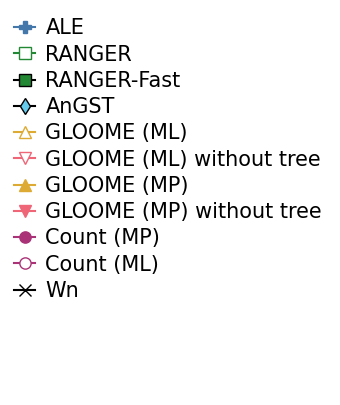

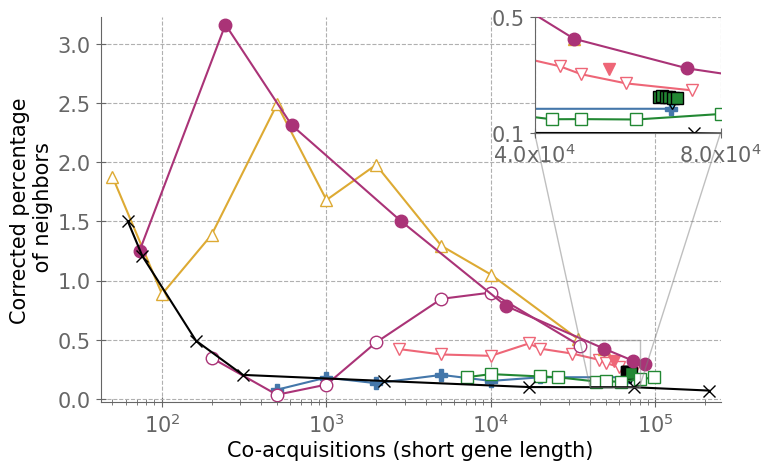

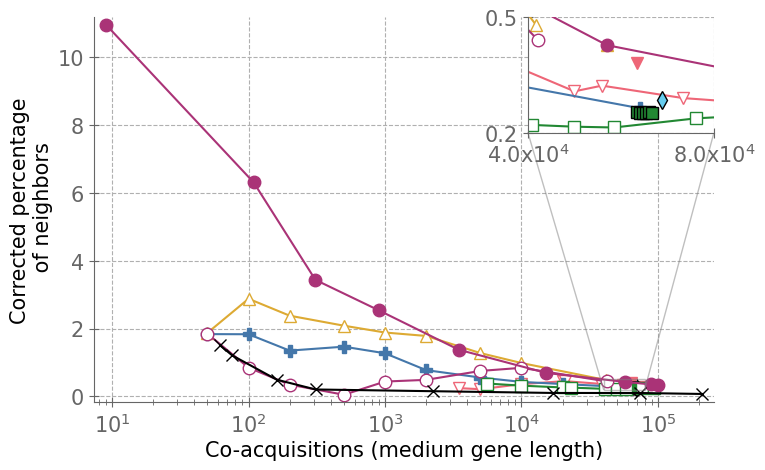

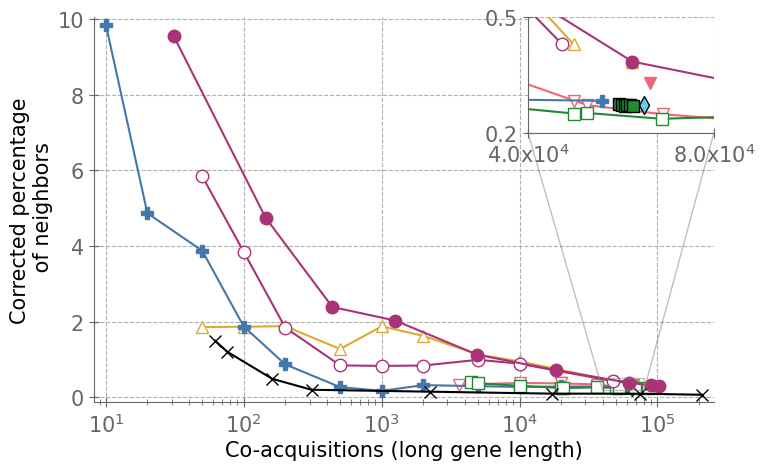

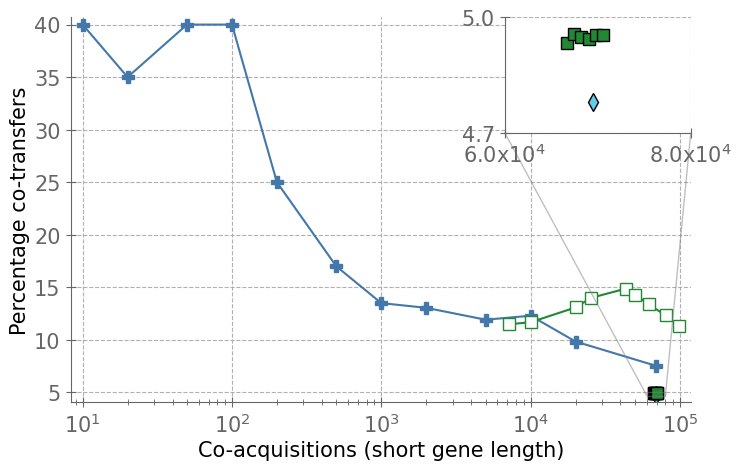

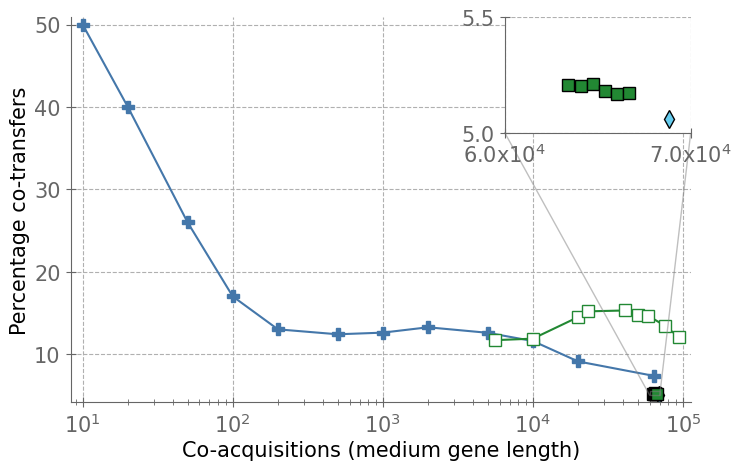

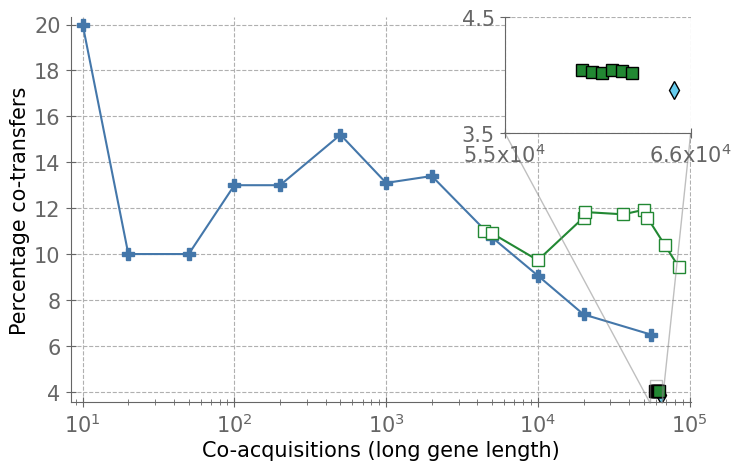

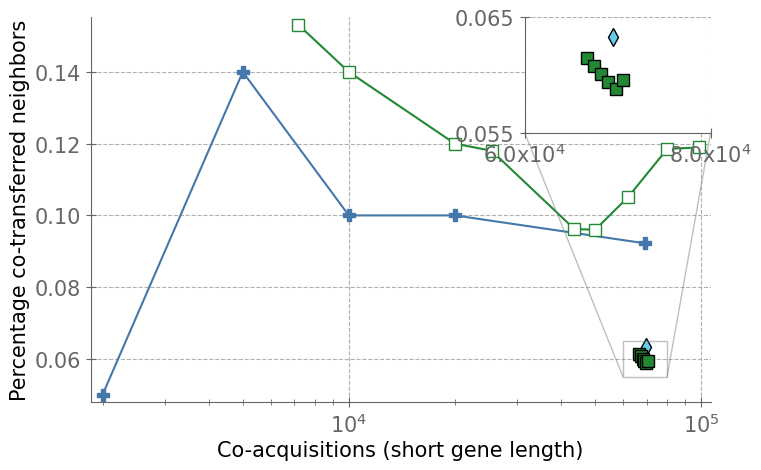

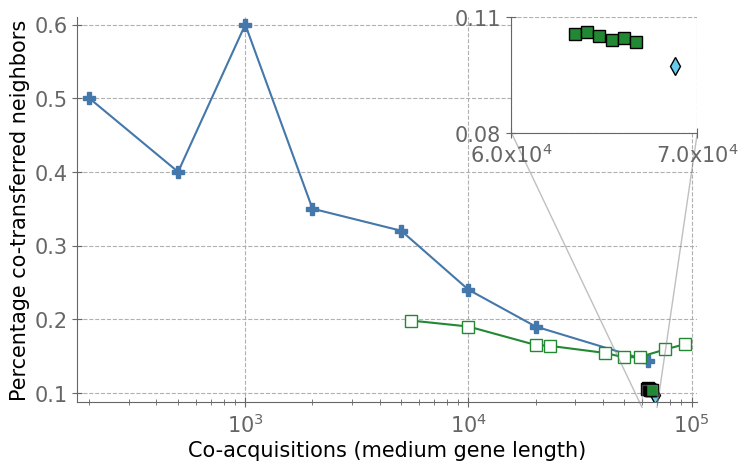

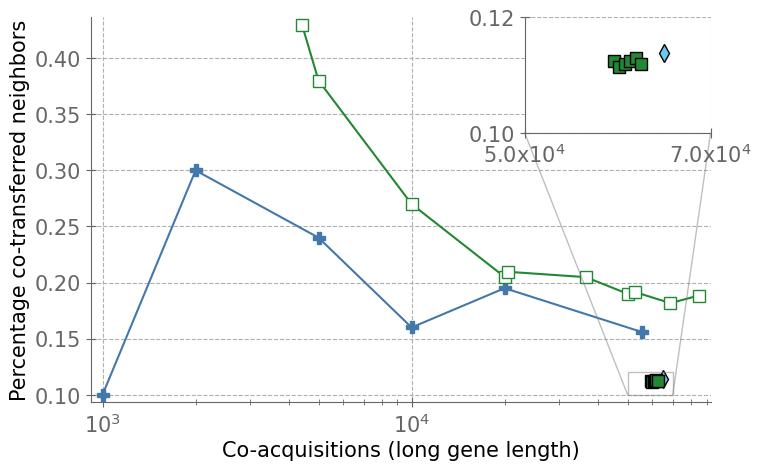

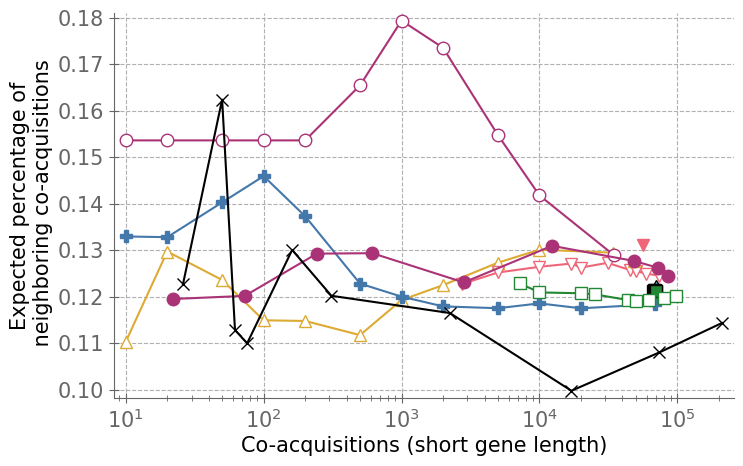

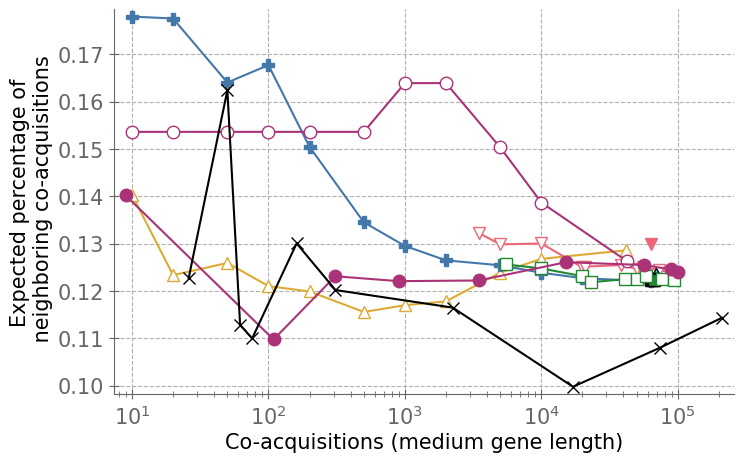

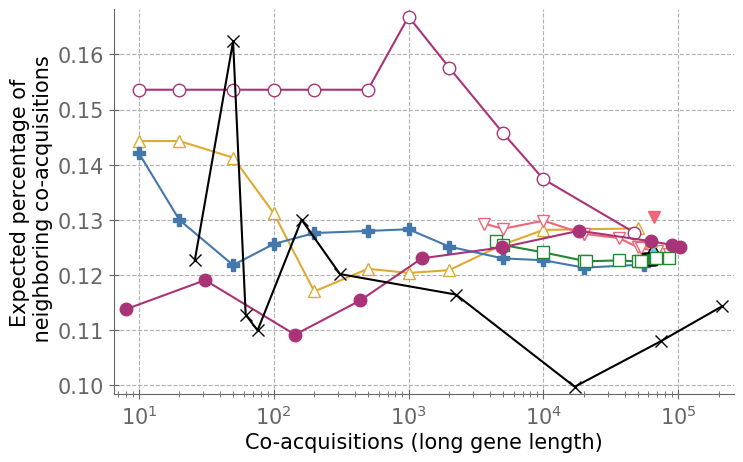

In [15]:

print("Note that y axis variable is the observed minus expected percentage of neighboring coacquisitions,\n \
      for a maximum of 1 intervening gene between coacquired genes\n \
      and x axis variable is the number of coacquisitions with known positions")

# print legend
print("Legend: ALE: + (blue), Ranger: square (green, filled for 'fast' version else empty),\n \
        ANGST: diamond, GLOOME: triangle-up (yellow, MP is filled, ML is empty), \n \
        GLOOME (without input species tree): triangle-down (red, MP is filled, ML is empty),\n \
        COUNT: circle (purple, MP is filled, ML is empty), Wn: x (black)")

# plot just the legend without any plot
fig, ax = plt.subplots(figsize=(1, 5))
for sm_key in marker_styles_dict.keys():
    if type(marker_styles_dict[sm_key]) is dict:
        method = sm_key
        ax.plot([], [], marker=marker_styles_dict[method]['marker_pyplot'],
            color=marker_styles_dict[method]['marker_color'],
            markerfacecolor=marker_styles_dict[method]['face_color'], label=marker_styles_dict[method]['label'])
ax.legend()
ax.axis('off')
plt.savefig(f'{plots_dir}/legend_tall.png', bbox_inches='tight')
plt.show()

# Plot excess over random expectation percentage of neighboring coacquisitions
fig, ax = plt.subplots(figsize=(8, 5))
inset_positions = [0.7, 0.7, 0.3, 0.3]
insets = [inset_positions]
x_inset_lims = [[4e4, 8e4]]
y_inset_lims = [[0.1, 0.5]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'short gene length': binned_coacq__by_gene_length_summary_dfs['short gene length']},
                            'coacquisitions with known positions', 'observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                            marker_styles_dict, x_inset_lims, y_inset_lims,
                            'Co-acquisitions', 'Corrected percentage\n of neighbors', insets)
# save fig
plt.savefig(f'{plots_dir}/neighboring_coacq_short_gene_length.png', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(8, 5))
y_inset_lims = [[0.2, 0.5]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'medium gene length': binned_coacq__by_gene_length_summary_dfs['medium gene length']},
                            'coacquisitions with known positions', 'observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                            marker_styles_dict, x_inset_lims, y_inset_lims,
                            'Co-acquisitions', 'Corrected percentage\n of neighbors', insets)
plt.savefig(f'{plots_dir}/neighboring_coacq_medium_gene_length.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
y_inset_lims = [[0.2, 0.5]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'long gene length': binned_coacq__by_gene_length_summary_dfs['long gene length']},
                            'coacquisitions with known positions', 'observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                            marker_styles_dict, x_inset_lims, y_inset_lims,
                            'Co-acquisitions', 'Corrected percentage\n of neighbors', insets)
plt.savefig(f'{plots_dir}/neighboring_coacq_long_gene_length.png', bbox_inches='tight')
plt.show()

# Plot percentage of co-transfers
fig, ax = plt.subplots(figsize=(8, 5))
insets = [[0.7, 0.7, 0.3, 0.3]]
x_inset_lims = [[6e4, 8e4]]
y_inset_lims = [[4.7, 5.0]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'short gene length': binned_coacq__by_gene_length_summary_dfs['short gene length']},
                                 'coacquisitions with known positions', 'cotransfer percentage',
                                    marker_styles_dict, x_inset_lims, y_inset_lims,
                                    'Co-acquisitions', 'Percentage co-transfers', insets)
plt.savefig(f'{plots_dir}/cotransfers_short_gene_length.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[6e4, 7e4]]
y_inset_lims = [[5, 5.5]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'medium gene length': binned_coacq__by_gene_length_summary_dfs['medium gene length']},
                                    'coacquisitions with known positions', 'cotransfer percentage',
                                    marker_styles_dict, x_inset_lims, y_inset_lims,
                                    'Co-acquisitions', 'Percentage co-transfers', insets)
plt.savefig(f'{plots_dir}/cotransfers_medium_gene_length.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[5.5e4, 6.6e4]]
y_inset_lims = [[3.5, 4.5]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'long gene length': binned_coacq__by_gene_length_summary_dfs['long gene length']},
                                    'coacquisitions with known positions', 'cotransfer percentage',
                                    marker_styles_dict, x_inset_lims, y_inset_lims,
                                    'Co-acquisitions', 'Percentage co-transfers', insets)
plt.savefig(f'{plots_dir}/cotransfers_long_gene_length.png', bbox_inches='tight')
plt.show()

# Plot percentage of co-transferred neighbors
fig, ax = plt.subplots(figsize=(8, 5))
insets = [[0.7, 0.7, 0.3, 0.3]]
x_inset_lims = [[6e4, 8e4]]
y_inset_lims = [[0.055, 0.065]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'short gene length': binned_coacq__by_gene_length_summary_dfs['short gene length']},
                               'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Percentage co-transferred neighbors', insets)
plt.savefig(f'{plots_dir}/cotransferred_neighbors_short_gene_length.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[6e4, 7e4]]
y_inset_lims = [[0.08, 0.11]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'medium gene length': binned_coacq__by_gene_length_summary_dfs['medium gene length']},
                               'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Percentage co-transferred neighbors', insets)
plt.savefig(f'{plots_dir}/cotransferred_neighbors_medium_gene_length.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[5e4, 7e4]]
y_inset_lims = [[0.10, 0.12]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'long gene length': binned_coacq__by_gene_length_summary_dfs['long gene length']},
                               'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Percentage co-transferred neighbors', insets)
plt.savefig(f'{plots_dir}/cotransferred_neighbors_long_gene_length.png', bbox_inches='tight')
plt.show()

# Plot expected percentage of neighboring coacquisitions
fig, ax = plt.subplots(figsize=(8, 5))
insets = [None]
x_inset_lims = [[1.3e4, 1.6e4]]
y_inset_lims = [[0.0, 0.5]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'short gene length': binned_coacq__by_gene_length_summary_dfs['short gene length']},
                               'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions', insets)
plt.savefig(f'{plots_dir}/expected_neighboring_coacq_short_gene_length.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
y_inset_lims = [[0.2, 0.5]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'medium gene length': binned_coacq__by_gene_length_summary_dfs['medium gene length']},
                               'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions', insets)
plt.savefig(f'{plots_dir}/expected_neighboring_coacq_medium_gene_length.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
y_inset_lims = [[0.2, 0.5]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'long gene length': binned_coacq__by_gene_length_summary_dfs['long gene length']},
                               'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions', insets)
plt.savefig(f'{plots_dir}/expected_neighboring_coacq_long_gene_length.png', bbox_inches='tight')
plt.show()


# Co-acquisitions by NOG size

By #genes in NOG

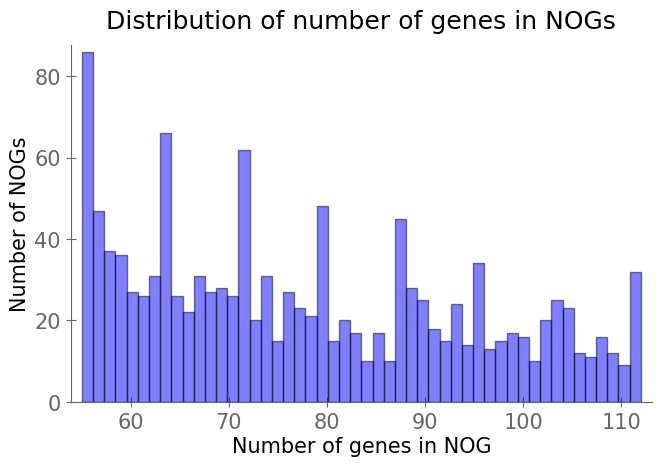

Small bin: 67.0, Medium bin: 86.0, Large bin: 112.0
Number of NOGs in small bin: 435
         Number of NOGs in medium bin: 448
         Number of NOGs in large bin: 444
Processing small #genes bin


Processing medium #genes bin
Method count.mp has less than 10 coacquisitions with known gene positions. Skipping.
Processing large #genes bin
Method count.mp has less than 10 coacquisitions with known gene positions. Skipping.


In [9]:
# bin the NOGs into small, medium, large based on #genes
# first plot the distribution of #genes for all NOGs
fig, ax = plt.subplots()
ax.hist(members_df['#genes'], 
        # bins=np.logspace(0, 4, 25),
        color='blue', alpha=0.5, edgecolor='black')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Number of genes in NOG')
ax.set_ylabel('Number of NOGs')
ax.set_title('Distribution of number of genes in NOGs')
plt.show()

# split the bins into 3 categories: small, medium, large
# the bins are equally spaced (similar number of NOGs in each bin, not in logspace)
total_num_nogs = members_df.shape[0]
small_bin = float(np.percentile(members_df['#genes'], 33))
medium_bin = float(np.percentile(members_df['#genes'], 66))
large_bin = float(np.percentile(members_df['#genes'], 100))
print(f'Small bin: {small_bin}, Medium bin: {medium_bin}, Large bin: {large_bin}')

small_nogs = members_df[members_df['#genes'].between(0, small_bin)]
medium_nogs = members_df[members_df['#genes'].between(small_bin, medium_bin)]
large_nogs = members_df[members_df['#genes'].between(medium_bin, large_bin)]
print(f'Number of NOGs in small bin: {small_nogs.shape[0]}\n \
        Number of NOGs in medium bin: {medium_nogs.shape[0]}\n \
        Number of NOGs in large bin: {large_nogs.shape[0]}')

# summarize the coacquisitions for each method across transfer thresholds
# for small, medium, large #genes bins
binned_coacq_by_genes_summary_dfs = summarize_coacquisitions_for_bins(coacquisitions_dfs, neighbor_genes_between_cutoffs, minimum_genome_size,
                                                            [small_nogs, medium_nogs, large_nogs], 
                                                            ['small #genes', 'medium #genes', 'large #genes'], min_coacquisitions)



Note that y axis variable is the observed minus expected percentage of neighboring coacquisitions,
       for a maximum of 1 intervening gene between coacquired genes
       and x axis variable is the number of coacquisitions with known positions
Legend: ALE: + (blue), Ranger: square (green, filled for 'fast' version else empty),
         ANGST: diamond, GLOOME: triangle-up (yellow, MP is filled, ML is empty), 
         GLOOME (without input species tree): triangle-down (red, MP is filled, ML is empty),
         COUNT: circle (purple, MP is filled, ML is empty), Wn: x (black)


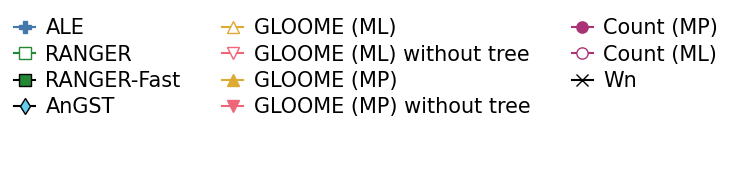

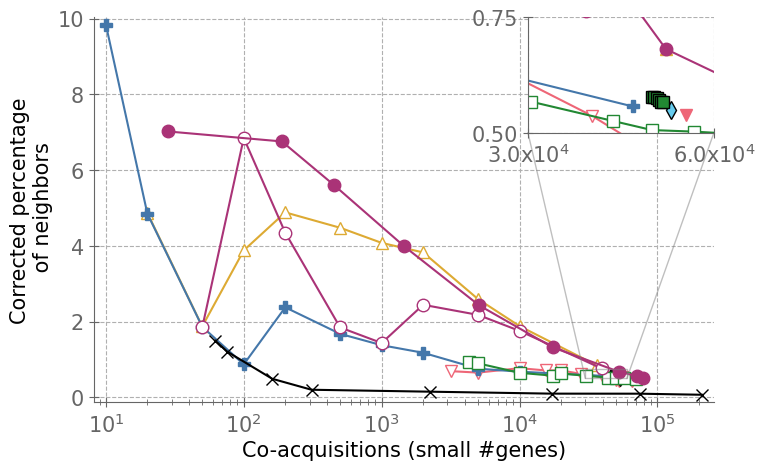

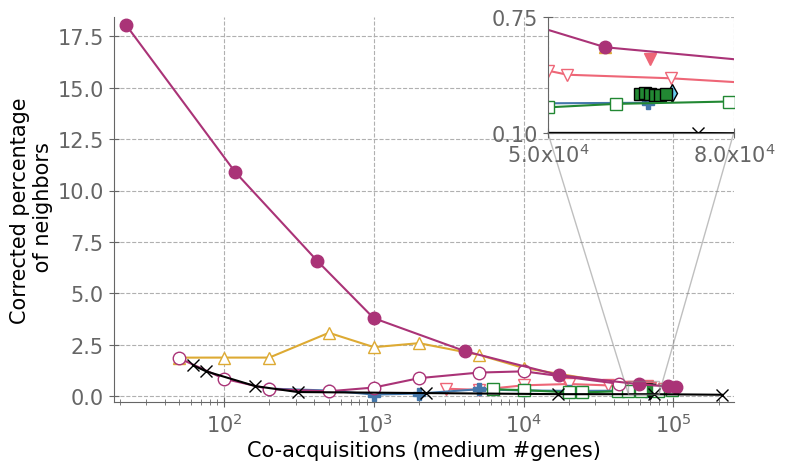

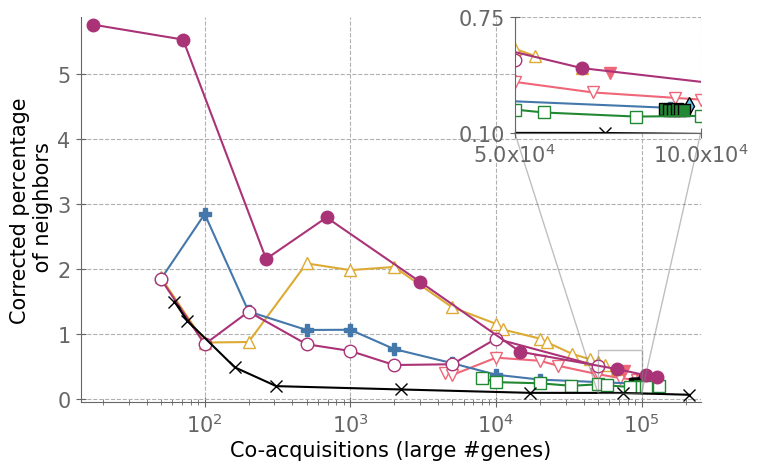

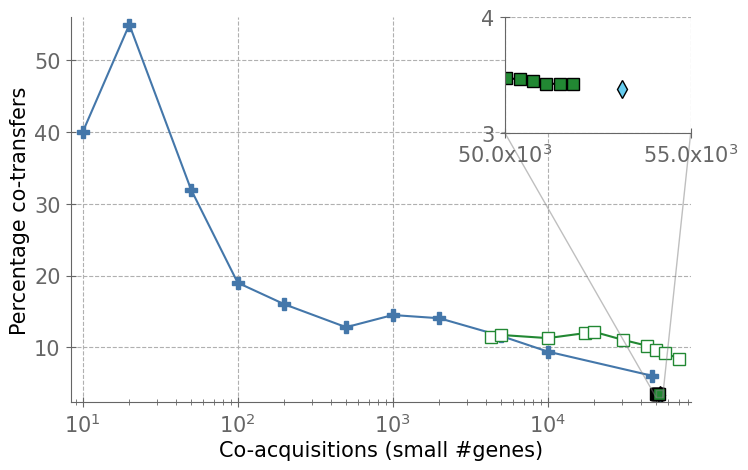

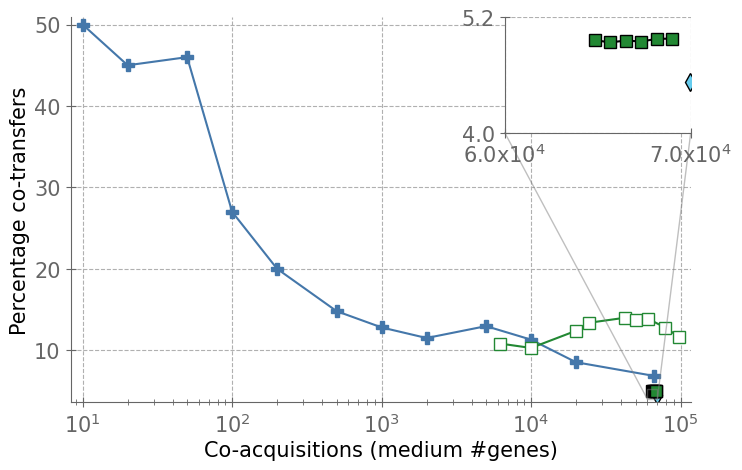

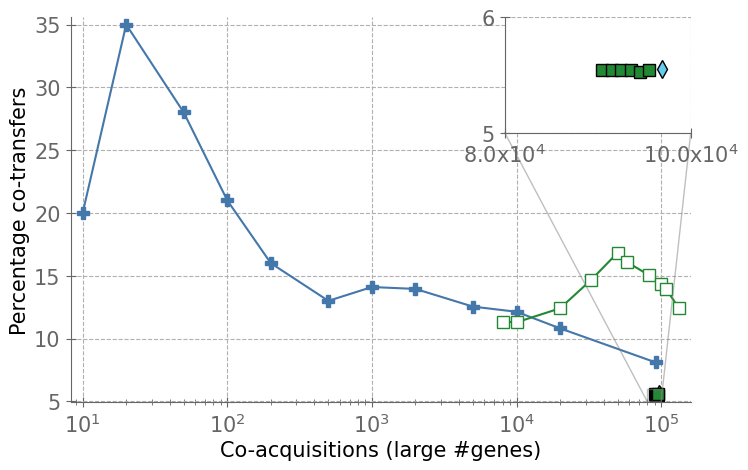

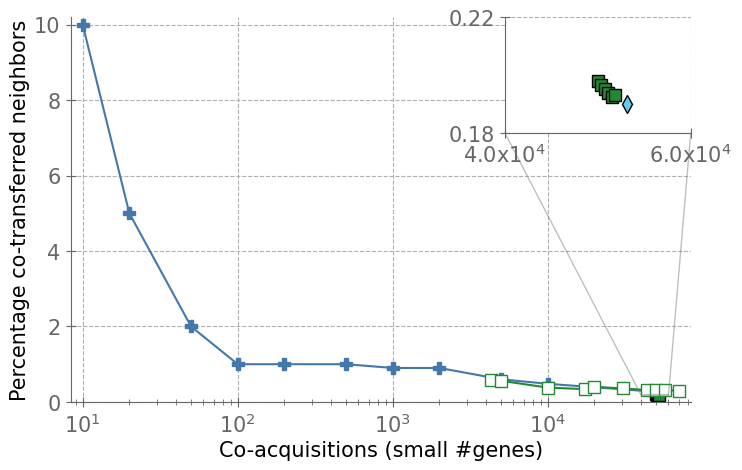

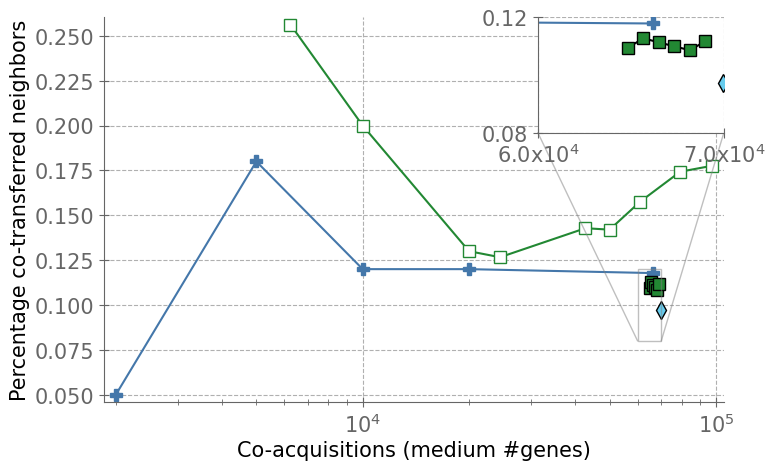

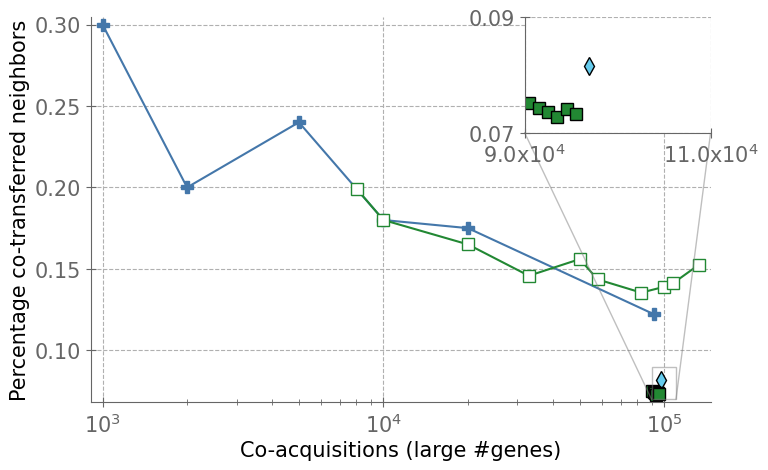

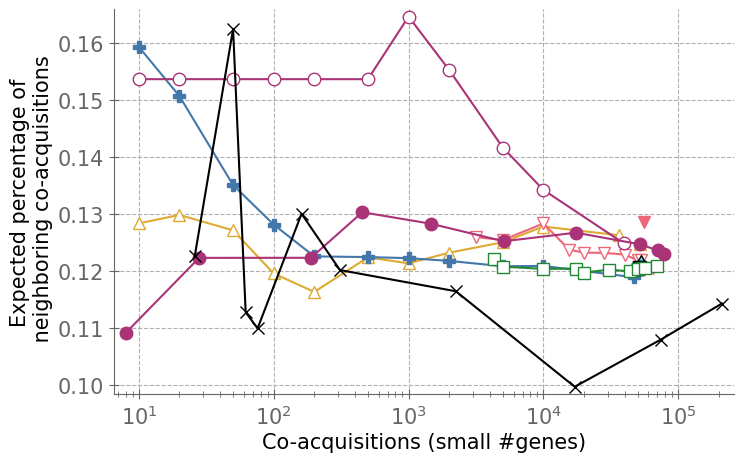

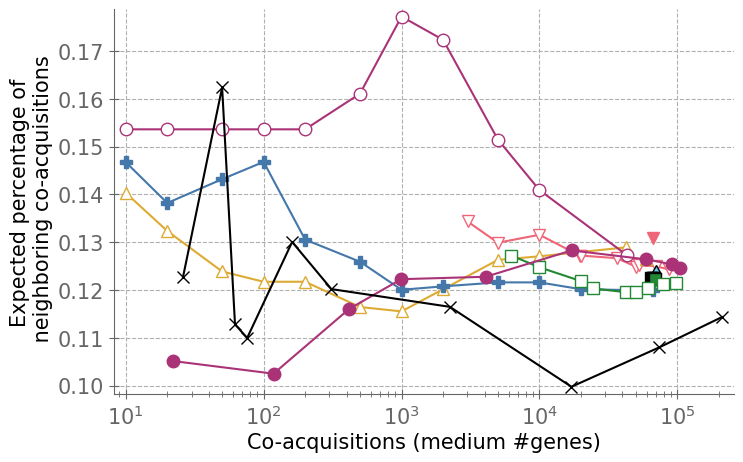

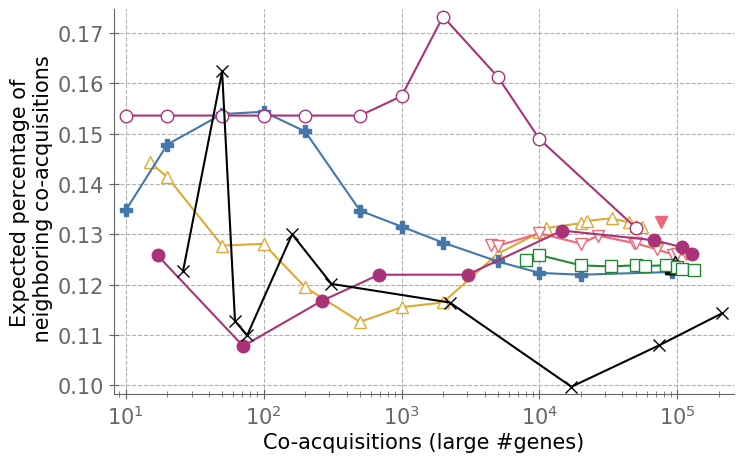

In [22]:

print("Note that y axis variable is the observed minus expected percentage of neighboring coacquisitions,\n \
      for a maximum of 1 intervening gene between coacquired genes\n \
      and x axis variable is the number of coacquisitions with known positions")

# print legend
print("Legend: ALE: + (blue), Ranger: square (green, filled for 'fast' version else empty),\n \
        ANGST: diamond, GLOOME: triangle-up (yellow, MP is filled, ML is empty), \n \
        GLOOME (without input species tree): triangle-down (red, MP is filled, ML is empty),\n \
        COUNT: circle (purple, MP is filled, ML is empty), Wn: x (black)")

# plot just the legend without any plot
fig, ax = plt.subplots(figsize=(8, 2))  # wide figure
for sm_key in marker_styles_dict.keys():
    if type(marker_styles_dict[sm_key]) is dict:
        method = sm_key
        ax.plot([], [], marker=marker_styles_dict[method]['marker_pyplot'],
                color=marker_styles_dict[method]['marker_color'],
                markerfacecolor=marker_styles_dict[method]['face_color'], label=marker_styles_dict[method]['label'])
ax.legend(ncol=3)  # arrange legend in 3 columns
ax.axis('off')
plt.savefig(f'{plots_dir}/legend_wide.png', bbox_inches='tight')
plt.show()

# Plot excess over random expectation percentage of neighboring coacquisitions
fig, ax = plt.subplots(figsize=(8, 5))
inset_positions = [0.7, 0.7, 0.3, 0.3]
insets = [inset_positions]
x_inset_lims = [[3e4, 6e4]]
y_inset_lims = [[0.5, 0.75]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'small #genes': binned_coacq_by_genes_summary_dfs['small #genes']},
                            'coacquisitions with known positions', 'observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                            marker_styles_dict, x_inset_lims, y_inset_lims,
                            'Co-acquisitions', 'Corrected percentage\n of neighbors', insets)
plt.savefig(f'{plots_dir}/neighboring_coacq_small_num_genes_nogs.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[5e4, 8e4]]
y_inset_lims = [[0.1, 0.75]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'medium #genes': binned_coacq_by_genes_summary_dfs['medium #genes']},
                            'coacquisitions with known positions', 'observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                            marker_styles_dict, x_inset_lims, y_inset_lims,
                            'Co-acquisitions', 'Corrected percentage\n of neighbors', insets)
plt.savefig(f'{plots_dir}/neighboring_coacq_medium_num_genes_nogs.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[5e4, 1e5]]
y_inset_lims = [[0.1, 0.75]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'large #genes': binned_coacq_by_genes_summary_dfs['large #genes']},
                            'coacquisitions with known positions', 'observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                            marker_styles_dict, x_inset_lims, y_inset_lims,
                            'Co-acquisitions', 'Corrected percentage\n of neighbors', insets)
plt.savefig(f'{plots_dir}/neighboring_coacq_large_num_genes_nogs.png', bbox_inches='tight')
plt.show()

# Plot percentage of co-transfers
fig, ax = plt.subplots(figsize=(8, 5))
insets = [[0.7, 0.7, 0.3, 0.3]]
x_inset_lims = [[5e4, 5.5e4]]
y_inset_lims = [[3, 4]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'small #genes': binned_coacq_by_genes_summary_dfs['small #genes']},
                                 'coacquisitions with known positions', 'cotransfer percentage',
                                    marker_styles_dict, x_inset_lims, y_inset_lims,
                                    'Co-acquisitions', 'Percentage co-transfers', insets)
plt.savefig(f'{plots_dir}/cotransfers_small_num_genes_nogs.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[6e4, 7e4]]
y_inset_lims = [[4, 5.2]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'medium #genes': binned_coacq_by_genes_summary_dfs['medium #genes']},
                                    'coacquisitions with known positions', 'cotransfer percentage',
                                    marker_styles_dict, x_inset_lims, y_inset_lims,
                                    'Co-acquisitions', 'Percentage co-transfers', insets)
plt.savefig(f'{plots_dir}/cotransfers_medium_num_genes_nogs.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[8e4, 1e5]]
y_inset_lims = [[5, 6]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'large #genes': binned_coacq_by_genes_summary_dfs['large #genes']},
                                    'coacquisitions with known positions', 'cotransfer percentage',
                                    marker_styles_dict, x_inset_lims, y_inset_lims,
                                    'Co-acquisitions', 'Percentage co-transfers', insets)
plt.savefig(f'{plots_dir}/cotransfers_large_num_genes_nogs.png', bbox_inches='tight')
plt.show()

# Plot percentage of co-transferred neighbors
fig, ax = plt.subplots(figsize=(8, 5))
insets = [[0.7, 0.7, 0.3, 0.3]]
x_inset_lims = [[4e4, 6e4]]
y_inset_lims = [[0.18, 0.22]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'small #genes': binned_coacq_by_genes_summary_dfs['small #genes']},
                               'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Percentage co-transferred neighbors', insets)
plt.savefig(f'{plots_dir}/cotransferred_neighbors_small_num_genes_nogs.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[6e4, 7e4]]
y_inset_lims = [[0.08, 0.12]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'medium #genes': binned_coacq_by_genes_summary_dfs['medium #genes']},
                               'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Percentage co-transferred neighbors', insets)
plt.savefig(f'{plots_dir}/cotransferred_neighbors_medium_num_genes_nogs.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
x_inset_lims = [[0.9e5, 1.1e5]]
y_inset_lims = [[0.07, 0.09]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'large #genes': binned_coacq_by_genes_summary_dfs['large #genes']},
                               'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Percentage co-transferred neighbors', insets)
plt.savefig(f'{plots_dir}/cotransferred_neighbors_large_num_genes_nogs.png', bbox_inches='tight')
plt.show()

# Plot expected percentage of neighboring coacquisitions
fig, ax = plt.subplots(figsize=(8, 5))
insets = [None]
x_inset_lims = [[1.3e4, 1.6e4]]
y_inset_lims = [[0.1, 0.4]]
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'small #genes': binned_coacq_by_genes_summary_dfs['small #genes']},
                               'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions', insets)
plt.savefig(f'{plots_dir}/expected_neighboring_coacq_small_num_genes_nogs.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'medium #genes': binned_coacq_by_genes_summary_dfs['medium #genes']},
                               'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions', insets)
plt.savefig(f'{plots_dir}/expected_neighboring_coacq_medium_num_genes_nogs.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
fig, ax = plot_multiple_figs_with_insets(fig, [ax], {'large #genes': binned_coacq_by_genes_summary_dfs['large #genes']},
                               'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions', insets)
plt.savefig(f'{plots_dir}/expected_neighboring_coacq_large_num_genes_nogs.png', bbox_inches='tight')
plt.show()